# ESSC4510/ EASC5510 
## Detect Periodicities
The following tutorial revise

1. Discrete world and nyquist frequncies
2. Linear model for fourier series 
    1. [Optional] Orthogonality of sine and cosine functions
3. Spectral density
4. Fourier transform application
 
Date: 24/02/2021

In [42]:
import os
from datetime import date
from math import exp, pi, sin, sqrt, floor, ceil
import numpy as np
import scipy.linalg as la
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

def eda_draw(*argv):
    bw = np.zeros((256,4));
    v = 0.9*(256 - np.linspace( 0, 255, 256 ))/255;
    bw[:,0] = v;
    bw[:,1] = v;
    bw[:,2] = v;
    bw[:,3] = np.ones(256);
    bwcmap = ListedColormap(bw);
    # size of plot
    W = 24;
    H = 6;
    fig1 = plt.figure(1);
    # figsize width and height in inches
    fig1.set_size_inches(W,H);
    ax1 = plt.subplot(1,1,1);
    plt.axis([0, W, -H/2, H/2]);
    plt.axis('off');
    LM = W/6;    # matrix width and heoght
    LV = W/40;   # vector width
    FS = 0.12;    # character width
    TO = 0.4;    # title vertical offset
    SP = 0.2;    # space between objects
    LS = 0.2;    # leading space
    p = LS; # starting x-position
    istitle=0; # flags presence of a title
    for a in argv:
        if isinstance(a,np.ndarray):
            sh = np.shape(a);
            if len(sh) == 1:  # conversion to nx1 array
                n = sh[0];
                m = 1;
                ap = a;
                a = np.zeros((n,1));
                a[:,0] = ap;
            else:
                n = sh[0];
                m = sh[1];
            if m==1:
                pold=p;
                left=p;
                right=p+LV;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LV;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
            else:
                pold=p;
                left=p;
                right=p+LM;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LM;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
        elif isinstance(a,str):
            ns = len(a);
            istitle=0;
            if( ns>=6 ):
                if 'title ' in a[0:6]:
                    istitle=1;
                    titlestr=a[6:];
            if( istitle != 1):
                plt.text(p,0,a);
                p = p + ns*FS + SP;
    plt.show();
    return 1;

def plot_spectrum(f, s, Nf):
    fig2 = plt.figure(2,figsize=(10,4));
    plt.rcParams['xtick.bottom'] = True;
    plt.rcParams['xtick.labelbottom'] = True;
    plt.rcParams['xtick.top'] = False;
    plt.rcParams['xtick.labeltop'] = False;

    ax1 = plt.subplot(1,3,1);
    plt.axis([0, f[-1,0], 0, 1.1*np.max(s[1:Nf,0]) ]);
    plt.plot(f[1:Nf,0],s[1:Nf,0],'k-');
    plt.xlabel('frequency f (cycles per day)');
    plt.ylabel('amplitude spectrum');
    plt.title('linear in frequency');

    ax1 = plt.subplot(1,3,2);
    Tmax = 1000;
    plt.axis([0, Tmax, 0, 1.1*np.max(s[1:Nf,0]) ]);
    plt.plot(np.reciprocal(f[1:Nf,0]),s[1:Nf,0],'k-');
    plt.xlabel('periot T (days)');
    plt.ylabel('amplitude spectrum');
    plt.title('linear in period');

    ax1 = plt.subplot(1,3,3);
    plt.semilogx(f[1:Nf,0], s[1:Nf,0], 'k-', basex=10);
    plt.axis([0.001, 1, 0, 1.1*np.max(s[1:Nf,0])])
    plt.xlabel('frequency f (cycles per day)');
    plt.ylabel('amplitude spectrum');
    plt.title('logarithmic in frequency');

    fig2.tight_layout()
    plt.show();

### 0.0 Useful function

Discrete world

What is the frequency steps in a discrete sampled time series?

From the class derivation, we have:

$$ \Delta f = \frac{1}{N\Delta t}$$
$$ \Delta \omega = \frac{2\pi}{N\Delta t}$$

where N is the number of observations, $\Delta t$ is the sampling spacing

In [2]:
def time_series(N, dt, tmin):
    """ Create auxillary variables t, f and w
        :param N: even integer 
            No. of samples.
        :param dt: float
            Sampling spacing of the data
        :param tmin: float
            Start time of the series
        
        :return: t (np.array,(N,1))
            time series
        :return: f (np.array,(N/2,1))
            frequency series
        :return: w (np.array, (N/2,1))
            angular frequency sereis
        :return: Nf (int)
            floor(N/2+1)
    """
    # making the auxillary variable t       
    tmax = tmin + dt*(N-1)
    t = np.zeros((N,1))
    t[:,0] = np.linspace(tmin, tmax, N)

    # Nyquist frequencies and frequency
    Nf = floor(N/2+1)
    fmax = 1/(2*dt)
    df = fmax/(N/2)
    f = np.zeros((Nf,1))
    f[:,0] = np.linspace(0,fmax,Nf)
    w = f * 2*np.pi
    
    return t, f, w, Nf



### 1.1 Nyquist's Sampling Theorem

Discrete data:

    What is the range of frequencies can we resolve from the discrete data?

Nyquist's Sampling Theorem:


    Considering the discrete sampling points of the data, the maximum frequency we can detected is 


The theroem stated that the priods shorter than two time increments cannot be detected in time series with evenly spaced samples. And in addition, the following we will demonstrate that any frequencies in the data that are higher than the *Nqyuist frequency*, $f_{ny}$ are erroneously mapped into the $(0,f_{ny})$ frequency ranges.

---

**Frequency higher than Nyquist's frequency is called *Aliasing*.**

Demo:
Considering a low frequency wave with  frequency $ 2\Delta f$

What is the corresponding Aliasing frequency?


low frequency 0.25132741228718347
high frequency 6.53451271946677


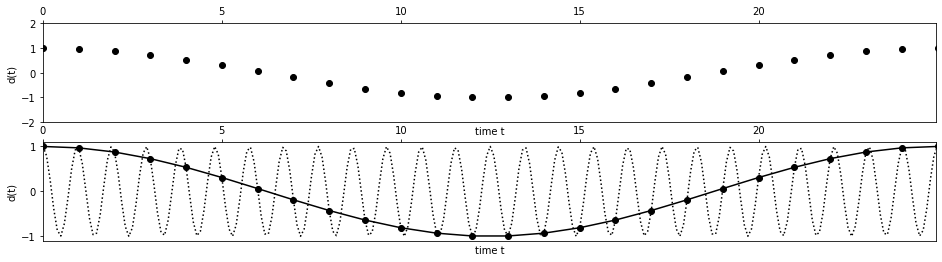

In [19]:
# example of aliasing
# make the auxillary variable t
N=100        # Number of data points
Dt=1         # Sampling spacing
tmin=0.0;
t, f, w, _ = time_series(N, Dt, tmin)

i = 4
dw = w[1,0]

# low frequency oscillation
w1= i*dw
print('low frequency', w1);
d1 = np.zeros((N,1))
d1[:,0] = np.cos( w1*t ).ravel()

# high frequency oscillation (higher than fny)
w2= (i+N)*dw
print('high frequency', w2)
d2 = np.zeros((N,1))
d2[:,0] = np.cos( w2*t ).ravel()


# set up higher sample rate time
N=500;
Dt2=0.1;
tmin=0.0;
tmax = tmin+Dt2*(N-1);
t3 = np.zeros((N,1));
t3[:,0] = np.linspace(tmin,tmax,N);
d3 = np.zeros((N,1));
d3[:,0] = np.cos( w2*t3 ).ravel();


#### plot signals
fig1 = plt.figure(1,figsize=(16,4));
plt.rcParams['xtick.bottom'] = False;
plt.rcParams['xtick.labelbottom'] = False;
plt.rcParams['xtick.top'] = True;
plt.rcParams['xtick.labeltop'] = True;

ax1 = plt.subplot(2,1,1);
plt.axis([tmin, tmax/2, -2, 2 ]);
#plt.plot(t,d1,'k-');
plt.plot(t,d2,'ko');
plt.xlabel('time t');
plt.ylabel('d(t)');

ax1 = plt.subplot(2,1,2,sharex=ax1);
plt.plot(t,d2,'k-');
plt.plot(t,d2,'ko');
plt.plot(t3,d3,'k:');
plt.xlabel('time t');
plt.ylabel('d(t)');
plt.show();


### 1.2 Data kernal for fourier series

Fourier series:

    All time series can be represented by a combinations of sines and cosines
    
$$ d(t_i) = A_1cos(w_1t_i) + B_1sin(w_1t_i) + A_2cos(w_2t_i) + B_2sin(w_2t_i)+...$$

The As and Bs are the model parameters and the corresponding frequencies are taken to be auxiliary variables. 

---

Assume we have an arbitary time series data. With 100 observations, dt = 1, starting from time zero.

What is the frequency steps in a discrete sampled time series?

From the class derivation, we have:



What is the range of the frequencies?
$$\textbf{f} = [0, \Delta f, 2\Delta f, ...$$

What is the number of model parameters in the linear system?

$$[A_1, A_2, B_2, ...$$


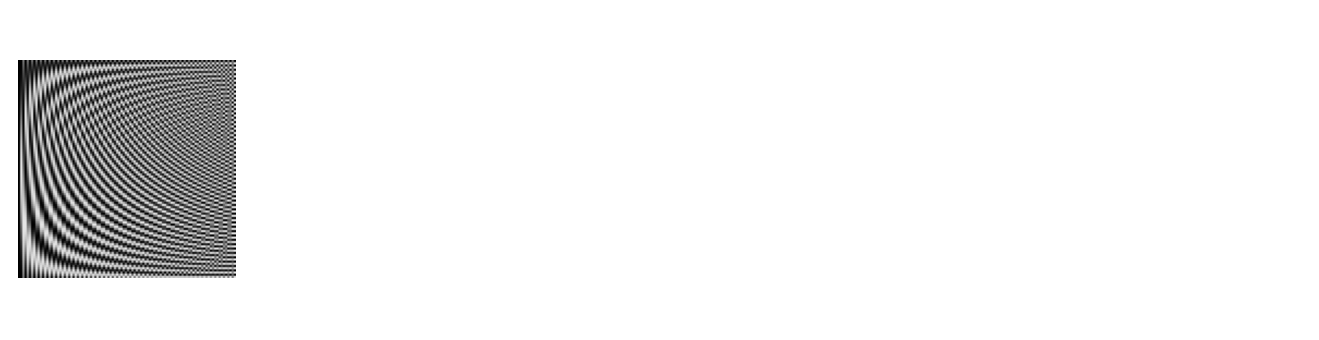

1

In [4]:
# make the auxillary variable t
N=100        # Number of data points
Dt=1         # Sampling spacing
tmin=0.0;
t, f, w, Nf = time_series(N, Dt, tmin)

# Create a data kernal 
# 1.1 Set up G 
M = N

def Fouier_kernal(N,M,t,w):
    G = np.zeros((N,M))

    # What is the value of zero frequency?
    %%
    
    Mo2 = floor(M/2)
    for i in range(1,Mo2):
        j = 2*i-1
        k = j+1
        G[:,j]=%%
        G[:,k]=%%

    # nyquist column
    G[:,M-1] = %%
    
    return G

G = Fouier_kernal(N,M,t,w)
eda_draw(G)

### 1.2 Examine G.TG

![title](Figures/Fourier_series_linear_model.png)
[Optional ]
Orthogonality of sines and cosines functions.

$$ G^T \cdot G$$

Data kernal G, can be considered as a combination of column vectors, i.e.
$$ [G^TG]_{ij} = \textbf{c}^{(i)T}\textbf{c}^{(j)} $$

The orthogonality of the sines and cosines fuctions suggested that 
$$\textbf{c}^{(i)T}\textbf{c}^{(j)} = 0 \text{ when i ≠ j} $$

Therefore, we have diagonal matrix and often used in the computation
$$[G^TG] = N diag(1,1/2,1/2,...,1/2,1/2,1)$$

And the inverse of $[G^TG]$ is
$$[G^TG]^{-1} = (1/N) diag(1,2,2,...,2,2,1)$$

**What is the implications?**

When the data are uncorrelated, then the model parameters **m**, which representing sines and cosines wave are also uncorrelated.

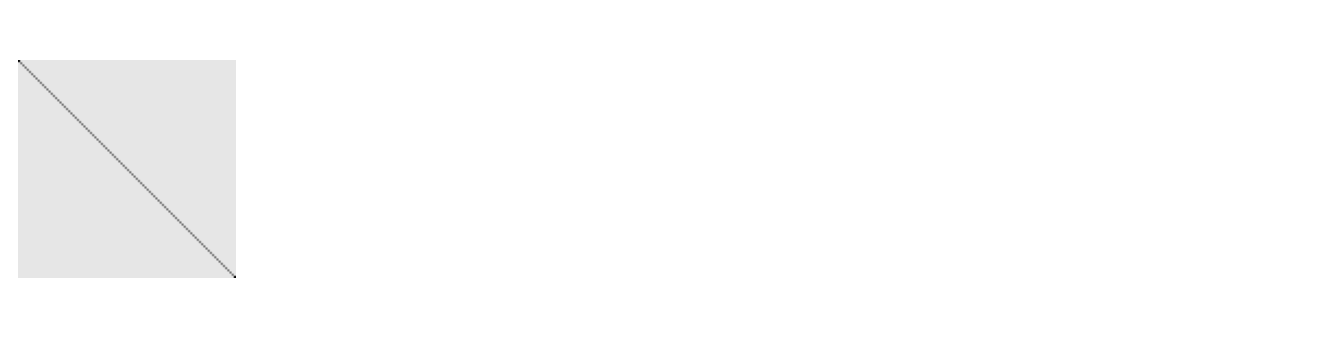

100.0


In [5]:
%% compute and plot GTG


# solve least squares problem using
# analytic formula for inv(GT*G)
gtgi = 2*np.ones((M,1))/N
gtgi[0,0]=1/N
gtgi[M-1,0]=1/N

### 1.3 Spectral and Power Spectral density
Recall the solution of Least square method
$$ m^{est} = [G^TG]^{-1}G^T d^{obs}$$
Demo: Neuse River discharge dataset

Try Black forest temperature data and compare the results in previous linear model assignment.

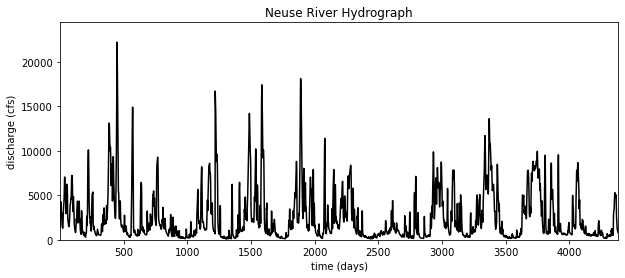

Analytical method - Time:  0.009105622999413754
Computational method - Time:  5.276657189000616


In [36]:
# Neuse River discharge dataset
# Read data: data/neues
D = np.genfromtxt('data/neuse.txt', delimiter='\t')

[Nraw, K]=D.shape
traw = np.zeros((Nraw,1))
traw[:,0] = D[:,0]
Dt = traw[1,0]-traw[0,0]
draw = np.zeros((Nraw,1))
draw[:,0] = D[:,1]

# round off to even number of points
No2 = floor(Nraw/2)
N=2*No2
d = np.zeros((N,1))
d[:,0]=draw[0:N,0]
t = np.zeros((N,1))
t[:,0]=traw[0:N,0]

# obtain the parameters from the dataset
Dt = t[1,0] - t[0,0]
tmin = t[0,0]
t, f, w, Nf = time_series(N, Dt, tmin)
Nw = Nf

# plot data
fig1 = plt.figure(1,figsize=(10,4));
plt.rcParams['xtick.bottom'] = True; plt.rcParams['xtick.labelbottom'] = True; plt.rcParams['xtick.top'] = False;plt.rcParams['xtick.labeltop'] = False;
ax1 = plt.subplot(1,1,1);
plt.axis([np.min(t), np.max(t), 0, 1.1*np.max(d) ]);
# plot attributes
plt.plot(t,d,'k-'); plt.xlabel('time (days)'); plt.ylabel('discharge (cfs)'); plt.title('Neuse River Hydrograph');
plt.show();

# Obatain some parameters and data kernal
Mo2 = No2
M = N
G = Fouier_kernal(N,M,t,w)

# solve least squares problem using
# analytic formula for inv(GT*G)
import timeit
start = timeit.default_timer()  # Compute runtime for the code section

###analytic formula for inv(GT*G)

%%

stop = timeit.default_timer()
print('Analytical method - Time: ', stop - start)  




# Traditional way
start = timeit.default_timer() # Compute runtime for the code section

### Traditional solving least square
%%

stop = timeit.default_timer()
print('Computational method - Time: ', stop - start)  


### 1.3.2  Spectral density

Amplitude spectral density = 
$$\left[\sqrt{A_1^2},\sqrt{A_2^2+B_2^2},+...+,\sqrt{A_{N/2}^2+B_{N/2}^2},\sqrt{A_{N/2+1}^2}\right]^T$$

Power spectral density = ?

Why do we have to use different x axis scale?

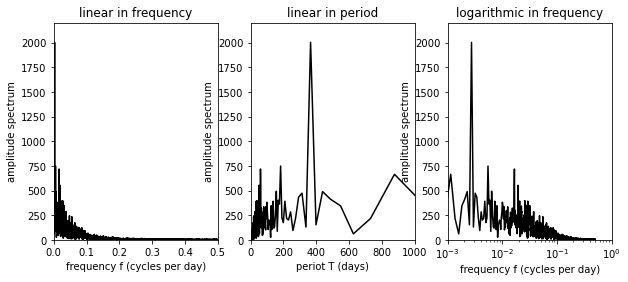

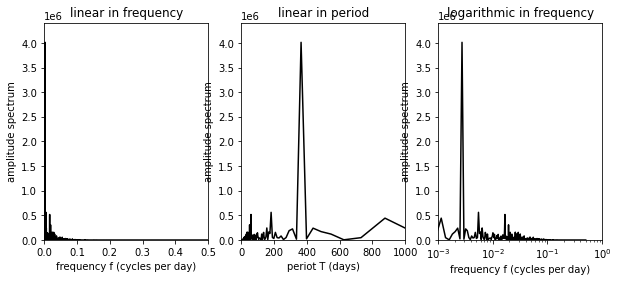

Error [[2.84399294e-15]]


In [23]:
# compute spectral density
s=np.zeros((Nw,1));
p=np.zeros((Nw,1));

# zero frequency
s[0,0]=%%
p[0,0]=%%
  
for i in range(1,Mo2):
    j = 2*i-1;
    k = j+1;
    s[i,0] = %%
    p[i,0] = %%

# Nyquist frequency
s[Nw-1,0]= %%
p[Nw-1,0]= %%

### plot spectrum
# Require, Amplitude Spectra - s and frequency -f
plot_spectrum(f,s,Nf)
plot_spectrum(f,p,Nf)

# check results
dpre =np.matmul( G, mest );
e = (d-dpre);
E = np.matmul( e.T, e );
print('Error', E);


### 1.4 Fourier Transform

Here we use the package `np.fft.rfft` to get rid of negative frequencies.

The inverse FFT can be computed via `np.fft.irfft`.

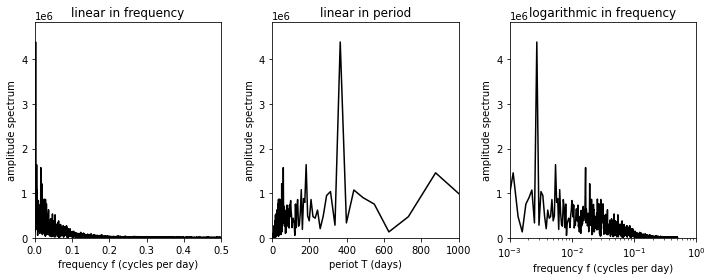

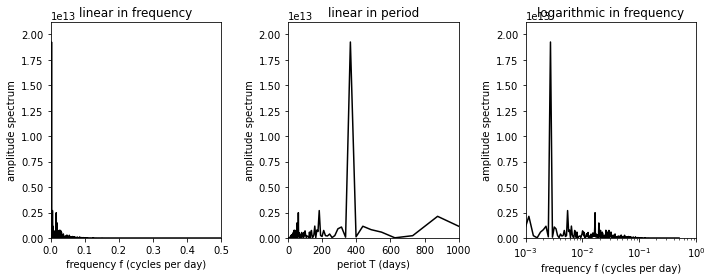

In [43]:
#  compute fourier coefficients
mest = np.zeros( (Nf,1), dtype=np.cdouble);
mest[:,0] = %%

# frequency
f = np.np.zeros( (Nf,1))
f[:,0] = %%

# ampltude spectrum
s = np.zeros( (Nf,1), dtype=np.double);
s[:,0] = %%

# compute power spectral density. note the normalization of (2/T).
s2 = np.zeros( (Nf,1), dtype=np.double);
s2[:,0] = %%

### plot spectrum
# Require, Amplitude Spectra - s and frequency -f
plot_spectrum(f,s,Nf)
plot_spectrum(f,s2,Nf)

### 1.5 Useful resources

Fourier series: https://www.youtube.com/watch?v=r6sGWTCMz2k&t=2s&ab_channel=3Blue1Brown

Visualizing fourier transform: https://www.youtube.com/watch?v=spUNpyF58BY&t=7s&ab_channel=3Blue1Brown
